<a href="https://colab.research.google.com/github/SidharthArya/Deep_Learning_Class_Manit/blob/add-license-1/Assignments/008_Treadmill.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import numpy
import xlrd
import pandas as pd
import os
import matplotlib.pyplot as plt
import io
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from scipy.signal import savgol_filter
from scipy import signal
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
# Create the LSTM model
from tensorflow import keras, convert_to_tensor, float32, make_ndarray
from tensorflow.compat.v1 import Session
from tensorflow.keras import layers, backend
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, MaxPool1D, TimeDistributed, RepeatVector, Conv2D
from keras.layers.merge import concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import random

# Fetching Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/TreadmilPublicData.zip .

In [ ]:
! unzip TreadmilPublicData.zip

Archive:  TreadmilPublicData.zip
  inflating: TreadmilPublicData/WBDS01walkT01ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT02ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT03ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT04ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT05ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT06ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT07ang.txt  
  inflating: TreadmilPublicData/WBDS01walkT08ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT01ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT02ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT03ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT04ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT05ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT06ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT07ang.txt  
  inflating: TreadmilPublicData/WBDS02walkT08ang.txt  
  inflating: TreadmilPublicData/WBDS03walkT01ang.txt  
  inflating: TreadmilPublicData/

In [ ]:
! cat TreadmilPublicData/WBDS42walkT08ang.txt

Time	RPelvisAngleX	RPelvisAngleY	RPelvisAngleZ	LPelvisAngleX	LPelvisAngleY	LPelvisAngleZ	RHipAngleX	RHipAngleY	RHipAngleZ	LHipAngleX	LHipAngleY	LHipAngleZ	RKneeAngleX	RKneeAngleY	RKneeAngleZ	LKneeAngleX	LKneeAngleY	LKneeAngleZ	RAnkleAngleX	RAnkleAngleY	RAnkleAngleZ	LAnkleAngleX	LAnkleAngleY	LAnkleAngleZ	RFootAngleX	RFootAngleY	RFootAngleZ	LFootAngleX	LFootAngleY	LFootAngleZ
0	-1.93068	1.64718	7.82864	0.0797252	0.405335	8.08608	-1.9267	-3.10686	27.1607	2.68142	-7.02699	26.6965	-0.613898	-17.6936	-0.711476	-0.427301	-20.767	-1.89581	1.23892	4.84861	0.942378	7.28611	9.07889	2.67855	0.726858	15.3813	21.3533	7.36643	18.72	26.1929
1	-1.90165	1.84404	7.6422	0.0948184	0.715908	7.9313	-1.71272	-3.11664	26.9592	2.61762	-7.21338	26.4676	-0.639423	-17.3542	0.318889	-0.299412	-19.9099	-1.01797	1.16732	4.97694	0.810651	7.17187	8.95258	2.42417	1.00896	14.7204	20.1569	7.7676	17.8735	24.8799
2	-1.84001	2.00946	7.46055	0.148765	1.01314	7.78059	-1.43809	-3.03953	26.7867	2.59451	-7.31184	26.1884	-0.69046	

In [ ]:
def plotData(person, speed):
  ini_name = "TreadmilPublicData/" 
  name ='WBDS' + ("" if person > 9 else "0") + str(person) + 'walkT' + "0" + str(speed)
  data = pd.read_csv(ini_name + name + 'ang.txt', delimiter = "\t")
  plt.plot(data['LKneeAngleZ'], label='Left Knee')
  plt.plot(data['LAnkleAngleZ'], label='Left Ankle')
  plt.plot(data['LHipAngleZ'], label='Left Hip')
  plt.ylabel("Angle")
  plt.xlabel("Time Steps")
  plt.legend()
  plt.show()
  print(data)

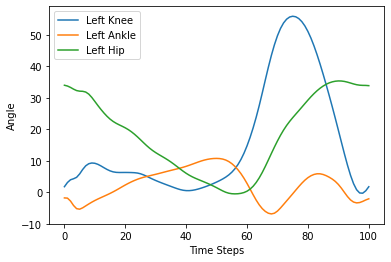

     Time  RPelvisAngleX  RPelvisAngleY  ...  LFootAngleX  LFootAngleY  LFootAngleZ
0       0        1.22974        3.19707  ...    -2.124730      11.2090     13.81770
1       1        1.17795        3.51900  ...    -1.846750      10.9443     12.29670
2       2        1.19296        3.83525  ...    -1.384440      10.9343     10.23790
3       3        1.29748        4.08656  ...    -0.723330      11.2620      8.11868
4       4        1.47220        4.22469  ...    -0.113339      11.6319      6.31756
..    ...            ...            ...  ...          ...          ...          ...
96     96        1.57769        1.91211  ...    -2.256570      12.2840     13.26760
97     97        1.51078        2.16201  ...    -2.532170      11.8276     14.23700
98     98        1.42465        2.41361  ...    -2.555830      11.5935     14.65520
99     99        1.32950        2.67979  ...    -2.401180      11.4240     14.42270
100   100        1.24176        2.97269  ...    -2.170350      11.1904     1

In [ ]:
plotData(1, 2)

In [ ]:
personalData = pd.read_excel(r"TreadmilPublicData/WBDSinfo.xlsx", engine='openpyxl')

In [ ]:
personalData.head()

,Subject,FileName,AgeGroup,Age,Height,Mass,Gender,Dominance,LegLength,Static1,Static2,GaitSpeed(m/s),TreadHands,FP_RightFoot,FP_LeftFoot,Notes,BorgScale,Unnamed: 17
0,1,WBDS01static1.c3d,Young,25,172.5,74.3,M,R,0.89,Yes,No,--,--,--,--,--,10.0,NaN
1,1,WBDS01walkT01.c3d,Young,25,172.5,74.3,M,R,0.89,Yes,No,0.49,No,--,--,--,10.0,NaN
2,1,WBDS01walkT02.c3d,Young,25,172.5,74.3,M,R,0.89,Yes,No,0.67,No,--,--,--,10.0,NaN
3,1,WBDS01walkT03.c3d,Young,25,172.5,74.3,M,R,0.89,Yes,No,0.85,No,--,--,--,10.0,NaN
4,1,WBDS01walkT04.c3d,Young,25,172.5,74.3,M,R,0.89,Yes,No,1.03,No,--,--,--,10.0,NaN


In [ ]:
personalData.shape

(6915, 18)

In [ ]:
filter = personalData["FileName"]=="WBDS01walkT01.c3d"
  
# filtering data 
dt = personalData.loc[filter]
  
# display 
dt.iloc[0]['Age']

25

In [ ]:
def todot(a,dt):
  x=len(a)
  b=numpy.zeros(a.shape)
  b[0]=a[0]/dt
  for i in range(1,x):
    b[i]=(a[i]-a[i-1])/dt
  return b

In [ ]:
def plotDot(jointAngle, jointAngleDot, time):
  fig = plt.figure(figsize=(10,10))
  ax = fig.gca(projection='3d')
  z = numpy.linspace(0, time/100, time - 1)
  ax.plot(jointAngle, jointAngleDot, z)
  ax.set_xlabel("joint angle")
  ax.set_ylabel("angular velocity")
  plt.show()

# Data Preprocessing

In [283]:
#multivariate time series
#WBDS01walkT01.c3d
#hip = 0, knee = 1, ankle = 2
#input => [Age, Height, Mass, Gender, GaitSpeed, LegLength, Dominance, jointNumber]
#outputShape = 101 * 3 (hip, knee, ankle)
person1_x = []
person1_y = []
person2_x = []
person2_y = []
hip_test_x = []
ankle_test_x = []
knee_test_x = []
hip_test_y = []
ankle_test_y = []
knee_test_y = []
personal_information = []
def dataPrep():
  train_x, train_y, test_x, test_y = [], [], [], []
  prev = -1
  for i in range(1, 43):
    flagPerson = 0
    curr = random.randint(1, 8)
    for j in range(1, 9):
      temp_x = []
      # temp_y = []
      ini_name = "TreadmilPublicData/" 
      name ='WBDS' + ("" if i > 9 else "0") + str(i) + 'walkT' + "0" + str(j)
      filter = personalData["FileName"]==name + ".c3d"
      dt = personalData.loc[filter]
      if flagPerson == 0:
        flagPerson = 1
        personal_information.append([dt.iloc[0]['Age'], dt.iloc[0]['Height'], dt.iloc[0]['Mass'], 
                          dt.iloc[0]['GaitSpeed(m/s)'], dt.iloc[0]['LegLength']])
      try:
        data = pd.read_csv(ini_name + name + 'ang.txt', delimiter = "\t")
        for joint in range(3):
          temp_x = []
          for _ in range(101):
            temp_x.append([dt.iloc[0]['Age'], dt.iloc[0]['Height'], dt.iloc[0]['Mass'], (0 if dt.iloc[0]['Gender'] == 'M' else 1), 
                          dt.iloc[0]['GaitSpeed(m/s)'], dt.iloc[0]['LegLength'], joint])
            
          if i == 1:
            person1_x.append(temp_x.copy())
          if i == 2:
            person2_x.append(temp_x.copy())
            
          if curr != j:
            # print("train =>", i, j)
            train_x.append(temp_x.copy())
            # train_y.append(temp_y.copy())
          else:
            test_x.append(temp_x.copy())

            if joint == 0:
              hip_test_x.append(temp_x.copy())
              hip_test_y.append(data['LHipAngleZ'])
            
            elif joint  == 1:
              knee_test_x.append(temp_x.copy())
              knee_test_y.append(data['LKneeAngleZ'])
            
            else:
              ankle_test_x.append(temp_x.copy())
              ankle_test_y.append(data['LAnkleAngleZ'])

        if curr != j:
          # train_y.append(temp_y.copy())
          train_y.append(data['LHipAngleZ'])
          train_y.append(data['LKneeAngleZ'])
          train_y.append(data['LAnkleAngleZ'])
        else:
          # test_y.append(temp_y.copy())
          test_y.append(data['LHipAngleZ'])
          test_y.append(data['LKneeAngleZ'])
          test_y.append(data['LAnkleAngleZ'])
        if i == 1:
          person1_y.append(data['LHipAngleZ'])
          person1_y.append(data['LKneeAngleZ'])
          person1_y.append(data['LAnkleAngleZ'])
        if i == 2:
          person2_y.append(data['LHipAngleZ'])
          person2_y.append(data['LKneeAngleZ'])
          person2_y.append(data['LAnkleAngleZ'])
      except:
        # print(str(e))
        continue
    
  train_x = numpy.array(train_x)
  train_y = numpy.array(train_y)
  test_x = numpy.array(test_x)
  test_y = numpy.array(test_y)

  return train_x, train_y, test_x, test_y

   

In [284]:
train_x, train_y, test_x, test_y = dataPrep()

In [285]:
n_outputs = 101
input_shape = train_x.shape[1:]

In [289]:
person1_x = numpy.array(person1_x)
person2_x = numpy.array(person2_x)
person1_y = numpy.array(person1_y)
person2_y = numpy.array(person2_y)

In [290]:
train_x.max(), train_x.min(), test_x.max(), test_x.min(), person1_x.max(), person1_x.min()

(192.0, 0.0, 192.0, 0.0, 172.5, 0.0)

In [291]:
train_y.max(), train_y.min(), test_y.max(), test_y.min(), person1_y.max(), person1_y.min()

(74.3077, -26.855999999999998, 73.6946, -23.72, 65.3264, -17.6481)

In [292]:
t = numpy.concatenate([train_x, test_x, person1_x, person2_x])
ty = numpy.concatenate([train_y, test_y, person1_y, person2_y])
print(t.shape, train_x.shape, test_x.shape)
t_max = t.max(axis=(0,1))
t_min = t.min(axis=(0,1))
ty_max = ty.max(axis=(0,1))
ty_min = ty.min(axis=(0,1))
t_max, t_min, ty_max, ty_min

(1032, 101, 7) (858, 101, 7) (126, 101, 7)


(array([ 84.  , 192.  ,  95.4 ,   1.  ,   2.23,   0.98,   2.  ]),
 array([ 21.  , 147.  ,  44.9 ,   0.  ,   0.36,   0.71,   0.  ]),
 74.3077,
 -26.855999999999998)

In [293]:
train_x

array([[[ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ],
        ...,
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   0.  ]],

       [[ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ],
        ...,
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   1.  ]],

       [[ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   2.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   2.  ],
        [ 25.  , 172.5 ,  74.3 , ...,   0.49,   0.89,   2.  ],
        ...,
        [ 25

In [294]:
# Normalizing
train_x = (train_x-t_min)/(t_max-t_min)
test_x = (test_x-t_min)/(t_max-t_min)

In [295]:
person1_x = (person1_x-t_min)/(t_max-t_min)
person2_x = (person2_x-t_min)/(t_max-t_min)

In [296]:
person1_y = (person1_y - ty_min)/(ty_max - ty_min)
person2_y = (person2_y - ty_min)/(ty_max - ty_min)

In [297]:
train_y = (train_y - ty_min)/(ty_max - ty_min)

In [298]:
test_y = (test_y - ty_min)/(ty_max - ty_min)

In [299]:
train_x.max(), train_x.min(), test_x.max(), test_x.min(), person1_x.max(), person1_x.min()

(1.0, 0.0, 1.0, 0.0, 1.0, 0.0)

In [300]:
train_y.max(), train_y.min(), test_y.max(), test_y.min(), person1_y.max(), person1_y.min()

(1.0,
 0.0,
 0.9939395257389755,
 0.03099926159284407,
 0.9112201313316932,
 0.09101980255763678)

# LSTM Model

In [ ]:
import tensorflow as tf

In [ ]:
lstm_model = Sequential([
  LSTM(256, input_shape=input_shape),
  Dense(128, activation='relu'),
  Dropout(0.2),
  Dense(128, activation='relu'),
  Dropout(0.3),
  Dense(n_outputs, activation='relu')                     
])

In [ ]:
  lstm_model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
  lstm_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 256)               270336    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 101)               13029     
Total params: 332,773
Trainable params: 332,773
Non-trainable params: 0
________________________________________________

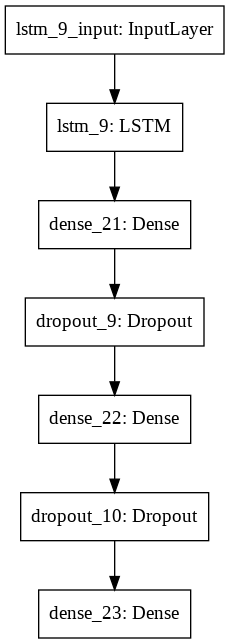

In [ ]:
tf.keras.utils.plot_model(lstm_model)

In [ ]:
train_y.shape

(861, 101)

In [ ]:

lstm_model_history = lstm_model.fit(train_x, train_y, epochs=200, validation_split=0.15, shuffle=True)

Epoch 1/200
23/23 [==============================] - 11s 394ms/step - loss: 0.1161 - accuracy: 0.0140 - val_loss: 0.0349 - val_accuracy: 0.0077
Epoch 2/200
23/23 [==============================] - 9s 374ms/step - loss: 0.0413 - accuracy: 0.0270 - val_loss: 0.0251 - val_accuracy: 0.0308
Epoch 3/200
23/23 [==============================] - 9s 374ms/step - loss: 0.0298 - accuracy: 0.0248 - val_loss: 0.0195 - val_accuracy: 0.0000e+00
Epoch 4/200
23/23 [==============================] - 9s 373ms/step - loss: 0.0226 - accuracy: 0.0258 - val_loss: 0.0126 - val_accuracy: 0.0000e+00
Epoch 5/200
23/23 [==============================] - 9s 374ms/step - loss: 0.0165 - accuracy: 0.0332 - val_loss: 0.0084 - val_accuracy: 0.0846
Epoch 6/200
23/23 [==============================] - 9s 374ms/step - loss: 0.0122 - accuracy: 0.0481 - val_loss: 0.0066 - val_accuracy: 0.1154
Epoch 7/200
23/23 [==============================] - 9s 377ms/step - loss: 0.0102 - accuracy: 0.0483 - val_loss: 0.0058 - val_accurac

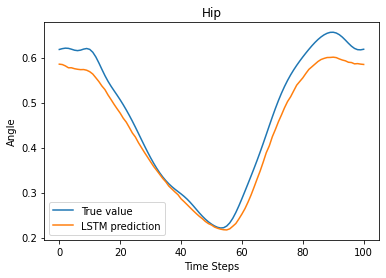

In [ ]:
plt.plot(test_y[0], label='True value')
plt.plot(lstm_model.predict(test_x)[0], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

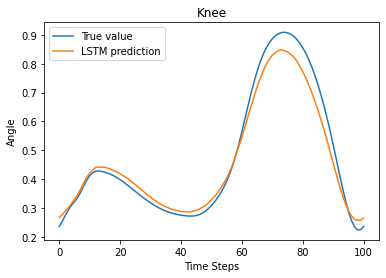

In [ ]:
plt.plot(test_y[1], label='True value')
plt.plot(lstm_model.predict(test_x)[1], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

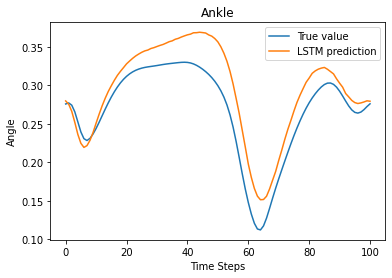

In [ ]:
plt.plot(test_y[2], label='True value')
plt.plot(lstm_model.predict(test_x)[2], label='LSTM prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

# CNN Model

In [ ]:
2#CNN model
cnn_model = Sequential([
                        Conv1D(64,3, activation='relu', input_shape=input_shape),
                        MaxPooling1D(pool_size=2),
                        Flatten(),
                        Dense(128, activation='relu'),
                        Dropout(0.3),
                        Dense(n_outputs, activation='relu')
])

cnn_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 99, 64)            1408      
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 49, 64)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_41 (Dense)             (None, 128)               401536    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 101)               13029     
Total params: 415,973
Trainable params: 415,973
Non-trainable params: 0
_______________________________________________

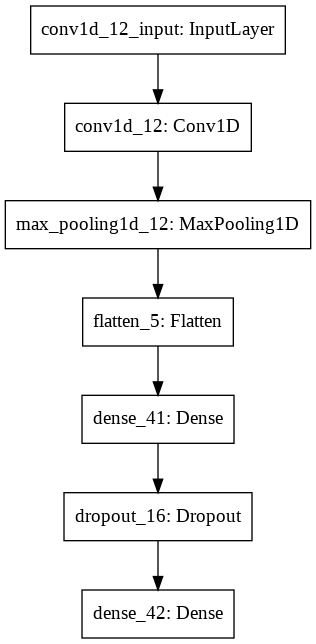

In [ ]:
tf.keras.utils.plot_model(cnn_model)

In [ ]:
cnn_model_history = cnn_model.fit(train_x, train_y, epochs=300, validation_split=0.15, shuffle=True)

Epoch 1/300
23/23 [==============================] - 1s 16ms/step - loss: 0.1076 - accuracy: 0.0265 - val_loss: 0.0409 - val_accuracy: 0.0462
Epoch 2/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0516 - accuracy: 0.0206 - val_loss: 0.0256 - val_accuracy: 0.0385
Epoch 3/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0328 - accuracy: 0.0299 - val_loss: 0.0214 - val_accuracy: 0.0385
Epoch 4/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0221 - accuracy: 0.0305 - val_loss: 0.0137 - val_accuracy: 0.0846
Epoch 5/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0187 - accuracy: 0.0351 - val_loss: 0.0102 - val_accuracy: 0.0538
Epoch 6/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0153 - accuracy: 0.0429 - val_loss: 0.0158 - val_accuracy: 0.0692
Epoch 7/300
23/23 [==============================] - 0s 10ms/step - loss: 0.0123 - accuracy: 0.0447 - val_loss: 0.0095 - val_accuracy: 0.0923
Epoch 

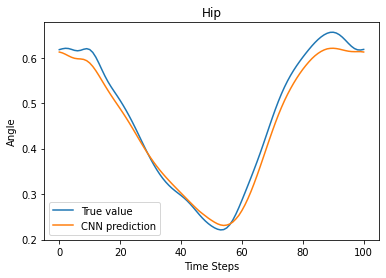

In [ ]:
plt.plot(test_y[0], label='True value')
plt.plot(cnn_model.predict(test_x)[0], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

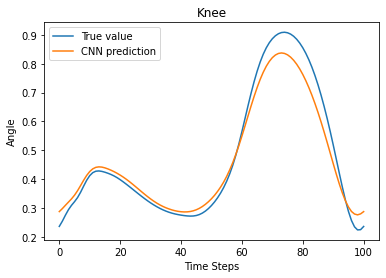

In [ ]:
plt.plot(test_y[1], label='True value')
plt.plot(cnn_model.predict(test_x)[1], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

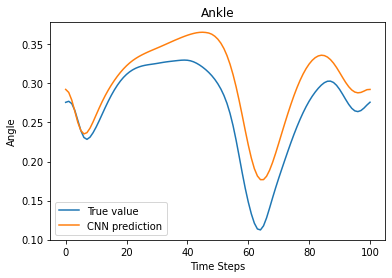

In [180]:
plt.plot(test_y[2], label='True value')
plt.plot(cnn_model.predict(test_x)[2], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

# GRU Model

In [ ]:
2#CNN model
gru_model = Sequential([
                        GRU(128,  input_shape=input_shape),
                        Dense(128, activation='relu'),
                        Dropout(0.3),
                        Dense(n_outputs, activation='relu')
])

gru_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 128)               52608     
_________________________________________________________________
dense_43 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 101)               13029     
Total params: 82,149
Trainable params: 82,149
Non-trainable params: 0
_________________________________________________________________


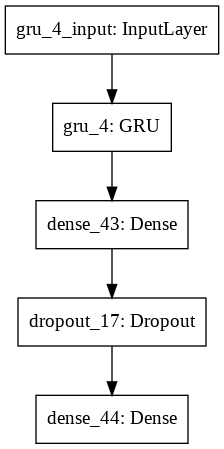

In [ ]:
tf.keras.utils.plot_model(gru_model)

In [ ]:
gru_model_history = gru_model.fit(train_x, train_y, epochs=300, validation_split=0.15, shuffle=True)

Epoch 1/300
23/23 [==============================] - 4s 91ms/step - loss: 0.1138 - accuracy: 0.0091 - val_loss: 0.0409 - val_accuracy: 0.0000e+00
Epoch 2/300
23/23 [==============================] - 2s 70ms/step - loss: 0.0421 - accuracy: 0.0125 - val_loss: 0.0315 - val_accuracy: 0.0000e+00
Epoch 3/300
23/23 [==============================] - 2s 71ms/step - loss: 0.0313 - accuracy: 0.0235 - val_loss: 0.0227 - val_accuracy: 0.0231
Epoch 4/300
23/23 [==============================] - 2s 72ms/step - loss: 0.0242 - accuracy: 0.0211 - val_loss: 0.0203 - val_accuracy: 0.0385
Epoch 5/300
23/23 [==============================] - 2s 72ms/step - loss: 0.0209 - accuracy: 0.0354 - val_loss: 0.0208 - val_accuracy: 0.0077
Epoch 6/300
23/23 [==============================] - 2s 73ms/step - loss: 0.0188 - accuracy: 0.0402 - val_loss: 0.0153 - val_accuracy: 0.0385
Epoch 7/300
23/23 [==============================] - 2s 71ms/step - loss: 0.0176 - accuracy: 0.0200 - val_loss: 0.0126 - val_accuracy: 0.046

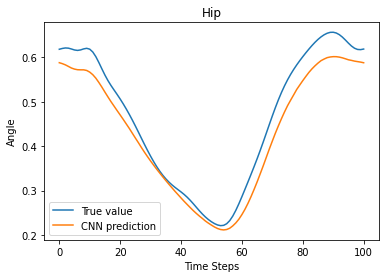

In [ ]:
plt.plot(test_y[0], label='True value')
plt.plot(gru_model.predict(test_x)[0], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

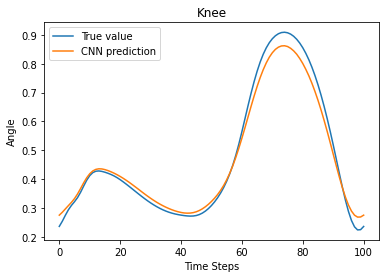

In [ ]:
plt.plot(test_y[1], label='True value')
plt.plot(gru_model.predict(test_x)[1], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

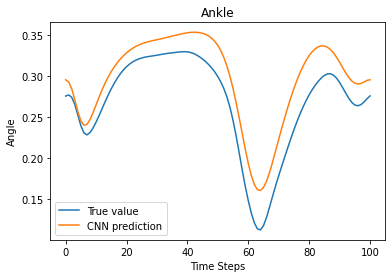

In [181]:
plt.plot(test_y[2], label='True value')
plt.plot(gru_model.predict(test_x)[2], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

# Ensembled Model

In [ ]:
cnn_model.trainable = False
gru_model.trainable = False
lstm_model.trainable = False

In [ ]:
input = Input(shape=input_shape)
x1 = cnn_model(input)
x2 = gru_model(input)
x3 = lstm_model(input)
x = concatenate([x1,x2,x3])
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(n_outputs, activation='relu')(x) 

In [ ]:
model = Model(input, output)

In [ ]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 101, 7)]     0                                            
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 101)          415973      input_10[0][0]                   
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 101)          82149       input_10[0][0]                   
__________________________________________________________________________________________________
sequential_8 (Sequential)       (None, 101)          332773      input_10[0][0]                   
____________________________________________________________________________________________

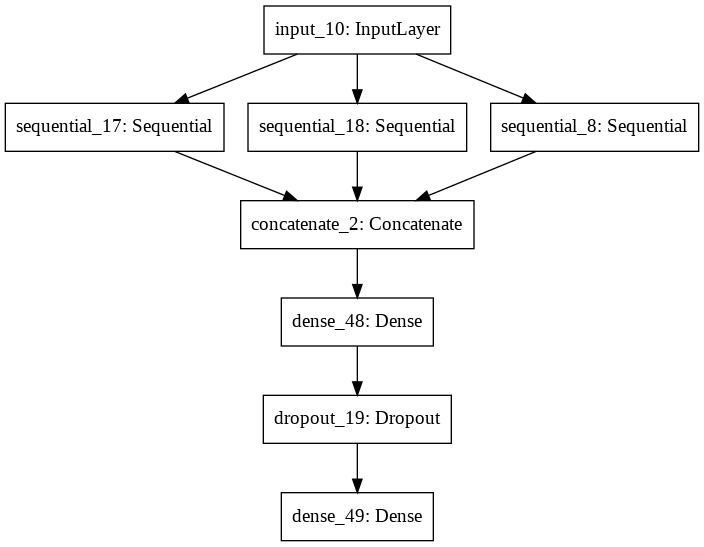

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
model_history = model.fit(train_x, train_y, epochs=300, validation_split=0.15, shuffle=True)

Epoch 1/300
23/23 [==============================] - 6s 134ms/step - loss: 0.0900 - accuracy: 0.0222 - val_loss: 0.0243 - val_accuracy: 0.0538
Epoch 2/300
23/23 [==============================] - 2s 98ms/step - loss: 0.0319 - accuracy: 0.0373 - val_loss: 0.0140 - val_accuracy: 0.0462
Epoch 3/300
23/23 [==============================] - 2s 97ms/step - loss: 0.0200 - accuracy: 0.0354 - val_loss: 0.0121 - val_accuracy: 0.0692
Epoch 4/300
23/23 [==============================] - 2s 98ms/step - loss: 0.0153 - accuracy: 0.0489 - val_loss: 0.0088 - val_accuracy: 0.1154
Epoch 5/300
23/23 [==============================] - 2s 95ms/step - loss: 0.0119 - accuracy: 0.0732 - val_loss: 0.0075 - val_accuracy: 0.1231
Epoch 6/300
23/23 [==============================] - 2s 97ms/step - loss: 0.0091 - accuracy: 0.0591 - val_loss: 0.0055 - val_accuracy: 0.0692
Epoch 7/300
23/23 [==============================] - 2s 97ms/step - loss: 0.0071 - accuracy: 0.0552 - val_loss: 0.0053 - val_accuracy: 0.1385
Epoch

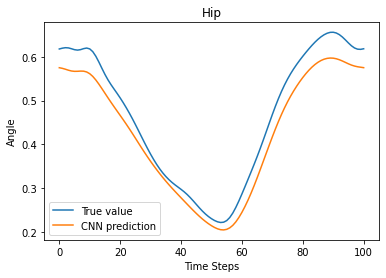

In [177]:
plt.plot(test_y[0], label='True value')
plt.plot(model.predict(test_x)[0], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Hip")
plt.legend()
plt.show()

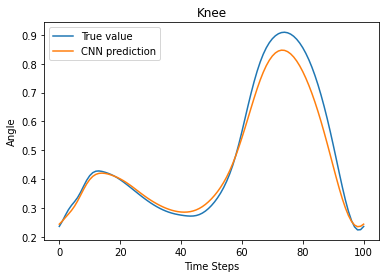

In [178]:
plt.plot(test_y[1], label='True value')
plt.plot(model.predict(test_x)[1], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Knee")
plt.legend()
plt.show()

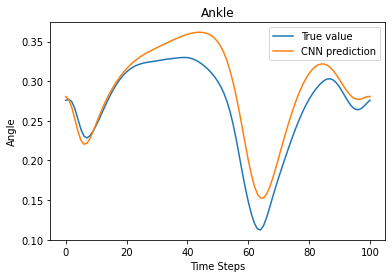

In [182]:
plt.plot(test_y[2], label='True value')
plt.plot(model.predict(test_x)[2], label='CNN prediction')
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.title("Ankle")
plt.legend()
plt.show()

# Comparison

In [237]:
temp = pd.read_csv('TreadmilPublicData/WBDS01walkT01ang.txt', delimiter="\t")
# '/content/drive/My Drive/Major/WBDS29walkT08ang.txt'

In [301]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((858, 101, 7), (858, 101), (126, 101, 7), (126, 101))

In [302]:
hip_test_x = (numpy.array(hip_test_x) - t_min)/(t_max - t_min)
ankle_test_x = (numpy.array(ankle_test_x)- t_min)/(t_max - t_min)
knee_test_x = (numpy.array(knee_test_x)- t_min)/(t_max - t_min)
hip_test_y = (numpy.array(hip_test_y)- ty_min)/(ty_max - ty_min)
ankle_test_y = (numpy.array(ankle_test_y)- ty_min)/(ty_max - ty_min)
knee_test_y = (numpy.array(knee_test_y)- ty_min)/(ty_max - ty_min)

In [303]:
hip_test_x.shape, hip_test_y.shape

((42, 101, 7), (42, 101))

In [304]:
knee_test_x.shape, knee_test_y.shape

((42, 101, 7), (42, 101))

In [242]:
ankle_test_x.shape, ankle_test_y.shape

((41, 101, 7), (41, 101))

In [305]:
hip_test_x.max(), hip_test_x.min()

(1.0, 0.0)

In [306]:
#Age, Height, Mass, Speed, LegLength
personal_information = numpy.array(personal_information)
personal_std = numpy.std(personal_information, axis=0)
personal_mean = numpy.mean(personal_information, axis=0)
personal_max = numpy.max(personal_information, 0)
personal_min = numpy.min(personal_information, 0)

In [307]:
personal_std

array([18.40396105, 10.88214435, 11.1080263 ,  0.06325317,  0.06654711])

In [308]:
personal_mean

array([ 42.64285714, 167.11904762,  67.76428571,   0.49880952,
         0.86089286])

In [309]:
personal_min

array([ 21.  , 147.  ,  44.9 ,   0.36,   0.71])

In [310]:
personal_max

array([ 84.  , 192.  ,  95.4 ,   0.61,   0.98])

In [311]:
person1_x = numpy.array(person1_x)
person1_y = numpy.array(person1_y)
person2_x = numpy.array(person2_x)
person2_y = numpy.array(person2_y)


In [312]:
person1_x.shape, person1_y.shape

((24, 101, 7), (24, 101))

In [313]:
person1_x.max(), person1_x.min()

(1.0, 0.0)

In [314]:
#for lstm model
#for hip
hip_test_prediction_lstm = lstm_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_lstm - hip_test_y)
hip_mean_lstm = numpy.mean(hip_diff)

knee_test_prediction_lstm = lstm_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_lstm - knee_test_y)
knee_mean_lstm = numpy.mean(knee_diff)

ankle_test_prediction_lstm = lstm_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_lstm - ankle_test_y)
ankle_mean_lstm = numpy.mean(ankle_diff)

hip_mean_lstm, knee_mean_lstm, ankle_mean_lstm

(0.029785974437552026, 0.031040775684308644, 0.02662286656586708)

In [315]:
#for cnn model
hip_test_prediction_cnn = cnn_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_cnn - hip_test_y)
hip_mean_cnn = numpy.mean(hip_diff)

knee_test_prediction_cnn = cnn_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_cnn - knee_test_y)
knee_mean_cnn = numpy.mean(knee_diff)

ankle_test_prediction_cnn = cnn_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_cnn - ankle_test_y)
ankle_mean_cnn = numpy.mean(ankle_diff)

hip_mean_cnn, knee_mean_cnn, ankle_mean_cnn

(0.03230764419929279, 0.033098781111877376, 0.024002668258958474)

In [316]:
#for gru model
hip_test_prediction_gru = gru_model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction_gru - hip_test_y)
hip_mean_gru = numpy.mean(hip_diff)

knee_test_prediction_gru = gru_model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction_gru - knee_test_y)
knee_mean_gru = numpy.mean(knee_diff)

ankle_test_prediction_gru = gru_model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction_gru - ankle_test_y)
ankle_mean_gru = numpy.mean(ankle_diff)

hip_mean_gru, knee_mean_gru, ankle_mean_gru

(0.02411768486540539, 0.03048257636745935, 0.024127558921955096)

In [317]:
#for ensembled model
hip_test_prediction = model.predict(hip_test_x)
hip_diff = numpy.abs(hip_test_prediction - hip_test_y)
hip_mean = numpy.mean(hip_diff)

knee_test_prediction = model.predict(knee_test_x)
knee_diff = numpy.abs(knee_test_prediction - knee_test_y)
knee_mean = numpy.mean(knee_diff)

ankle_test_prediction = model.predict(ankle_test_x)
ankle_diff = numpy.abs(ankle_test_prediction - ankle_test_y)
ankle_mean = numpy.mean(ankle_diff)

hip_mean, knee_mean, ankle_mean

(0.03147343971931011, 0.03704523132536735, 0.02551916011889861)

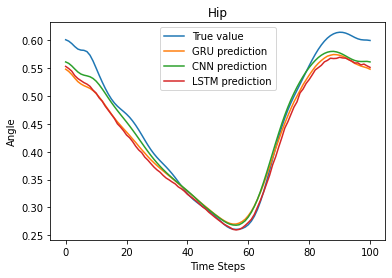

In [318]:
plt.plot(test_y[0], label='True value')
plt.plot(gru_model.predict(test_x)[0], label='GRU prediction')
plt.plot(cnn_model.predict(test_x)[0], label='CNN prediction')
plt.plot(lstm_model.predict(test_x)[0], label='LSTM prediction')
plt.title("Hip")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

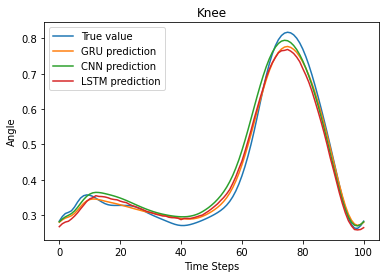

In [319]:
plt.plot(test_y[1], label='True value')
plt.plot(gru_model.predict(test_x)[1], label='GRU prediction')
plt.plot(cnn_model.predict(test_x)[1], label='CNN prediction')
plt.plot(lstm_model.predict(test_x)[1], label='LSTM prediction')
plt.title("Knee")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

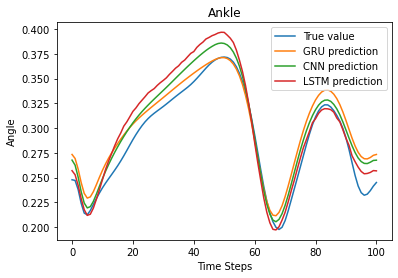

In [320]:
plt.plot(test_y[2], label='True value')
plt.plot(gru_model.predict(test_x)[2], label='GRU prediction')
plt.plot(cnn_model.predict(test_x)[2], label='CNN prediction')
plt.plot(lstm_model.predict(test_x)[2], label='LSTM prediction')
plt.title("Ankle")
plt.xlabel("Time Steps")
plt.ylabel("Angle")
plt.legend()
plt.show()

In [321]:
person_1_predict_gru = gru_model.predict(person1_x)
person_2_predict_gru = gru_model.predict(person2_x)
person_1_predict_cnn = cnn_model.predict(person1_x)
person_2_predict_cnn = cnn_model.predict(person2_x)
person_1_predict_lstm = lstm_model.predict(person1_x)
person_2_predict_lstm = lstm_model.predict(person2_x)
person_1_predict = model.predict(person1_x)
person_2_predict = model.predict(person2_x)

In [322]:
person_1_predict_gru.shape

(24, 101)

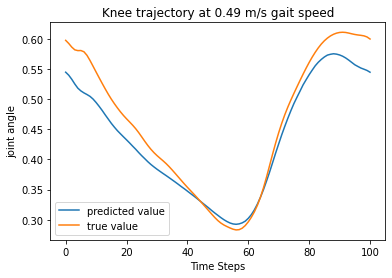

In [323]:
plt.plot(person_1_predict_gru[0], label="predicted value")
plt.plot(person1_y[0], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 0.49 m/s gait speed")
plt.legend()
plt.show()

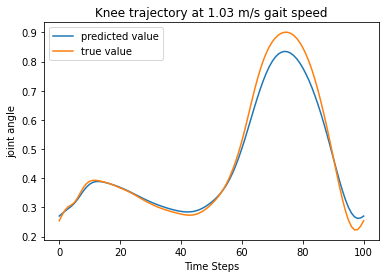

In [324]:
plt.plot(person_1_predict_gru[10], label="predicted value")
plt.plot(person1_y[10], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 1.03 m/s gait speed")
plt.legend()
plt.show()

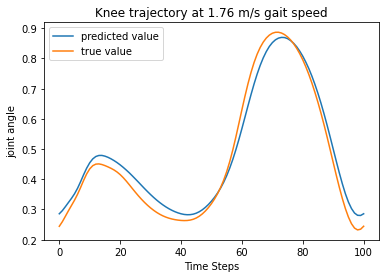

In [325]:
plt.plot(person_1_predict_gru[22], label="predicted value")
plt.plot(person1_y[22], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee trajectory at 1.76 m/s gait speed")
plt.legend()
plt.show()

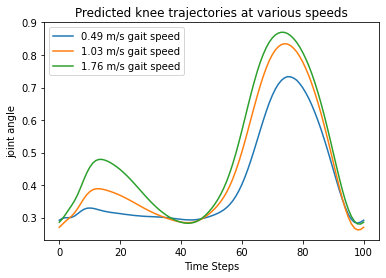

In [326]:
plt.plot(person_1_predict_gru[1], label="0.49 m/s gait speed")
plt.plot(person_1_predict_gru[10], label="1.03 m/s gait speed")
plt.plot(person_1_predict_gru[22], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted knee trajectories at various speeds")
plt.legend()
plt.show()

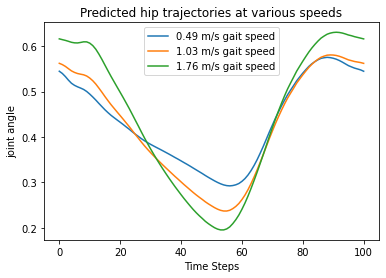

In [327]:
plt.plot(person_1_predict_gru[0], label="0.49 m/s gait speed")
plt.plot(person_1_predict_gru[9], label="1.03 m/s gait speed")
plt.plot(person_1_predict_gru[21], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted hip trajectories at various speeds")
plt.legend()
plt.show()

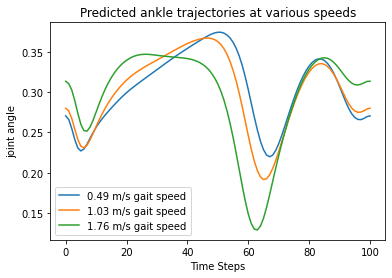

In [328]:
plt.plot(person_1_predict_gru[2], label="0.49 m/s gait speed")
plt.plot(person_1_predict_gru[11], label="1.03 m/s gait speed")
plt.plot(person_1_predict_gru[23], label="1.76 m/s gait speed")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Predicted ankle trajectories at various speeds")
plt.legend()
plt.show()

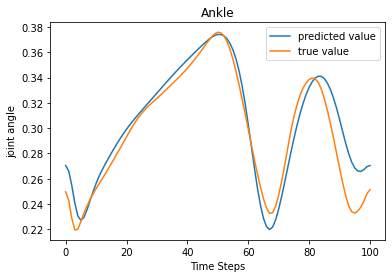

In [329]:
plt.plot(person_1_predict_gru[2], label="predicted value")
plt.plot(person1_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

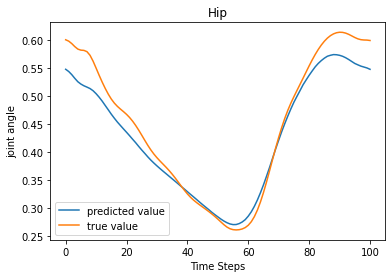

In [330]:
plt.plot(person_1_predict_gru[3], label="predicted value")
plt.plot(person1_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

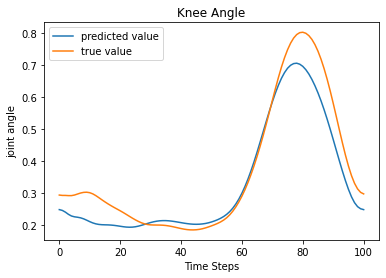

In [331]:
plt.plot(person_2_predict_gru[1], label="predicted value")
plt.plot(person2_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee Angle")
plt.legend()
plt.show()

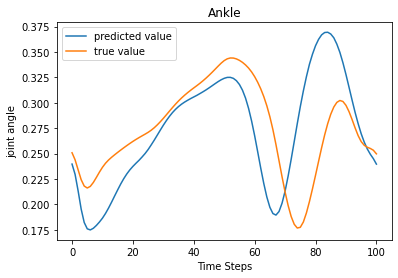

In [332]:
plt.plot(person_2_predict_gru[2], label="predicted value")
plt.plot(person2_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

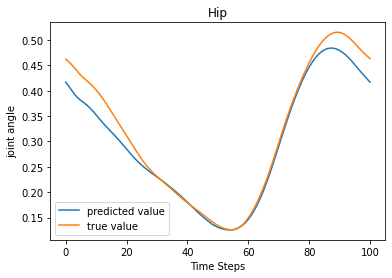

In [333]:
plt.plot(person_2_predict_gru[3], label="predicted value")

plt.plot(person2_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

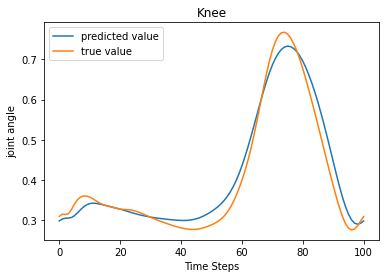

In [334]:
plt.plot(person_1_predict_cnn[1], label="predicted value")
plt.plot(person1_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Knee")
plt.legend()
plt.show()

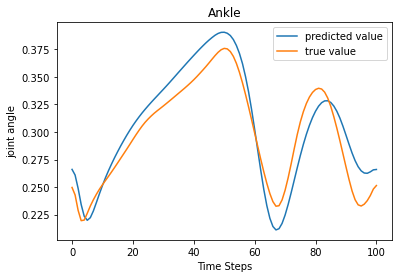

In [335]:
plt.plot(person_1_predict_cnn[2], label="predicted value")
plt.plot(person1_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

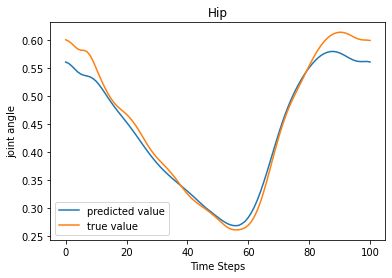

In [336]:
plt.plot(person_1_predict_cnn[3], label="predicted value")
plt.plot(person1_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

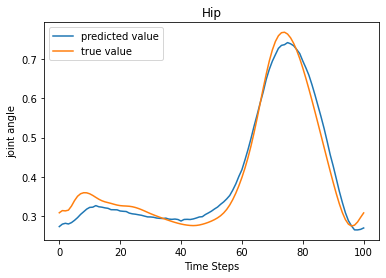

In [337]:
plt.plot(person_1_predict_lstm[1], label="predicted value")
plt.plot(person1_y[1], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

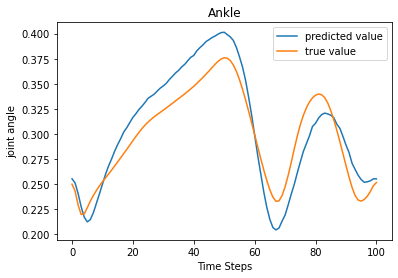

In [338]:
plt.plot(person_1_predict_lstm[2], label="predicted value")
plt.plot(person1_y[2], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Ankle")
plt.legend()
plt.show()

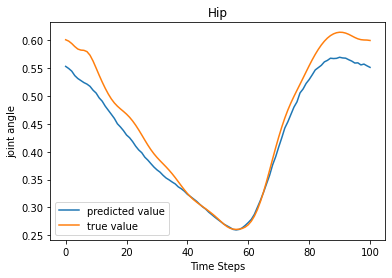

In [339]:
plt.plot(person_1_predict_lstm[3], label="predicted value")
plt.plot(person1_y[3], label="true value")
plt.xlabel("Time Steps")
plt.ylabel("joint angle")
plt.title("Hip")
plt.legend()
plt.show()

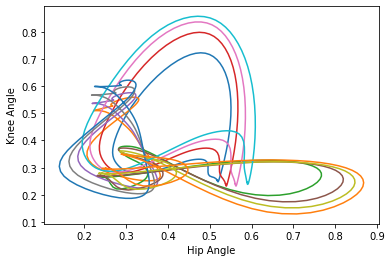

In [340]:
for i in range(0, 24, 2):
  plt.plot(person_1_predict[i], person_1_predict[i + 1])
plt.xlabel("Hip Angle")
plt.ylabel("Knee Angle")
plt.show()

In [341]:
dt = 0.5
knee_person_angularVelocity = todot(person_1_predict[i + 1], dt)

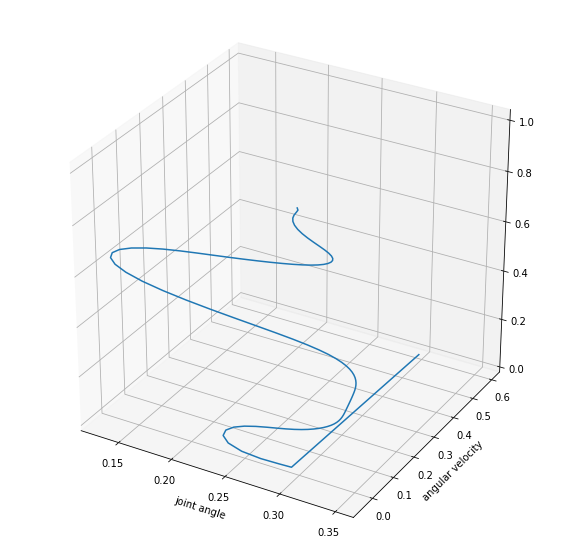

In [342]:
plotDot(person_1_predict[i + 1], knee_person_angularVelocity, 102)

In [343]:
hip_person_angularVelocity = todot(person_1_predict[i], dt)

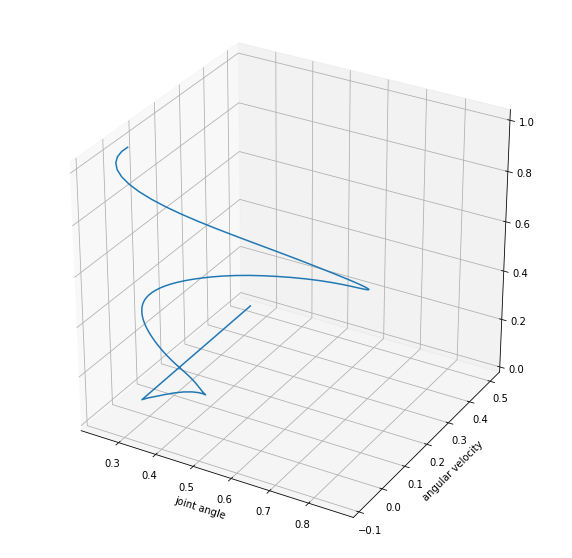

In [344]:
plotDot(person_1_predict[i], hip_person_angularVelocity, 102)